In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from denn import *
import matplotlib as mpl

In [2]:
exps  = ['exp1','exp2','exp3','exp4']
funcs = ['sphere','rastrigin','rosenbrock']
freq = 1

In [69]:
# funcs
pat = re.compile('.*/(exp\d)/(\w*)/nonn/freq(\d+)div(\w+)/(\w+)_\w+.csv')
decode_keys = ['experiment','function','freq','div','method']
nn_pat = re.compile('.*/(exp\d)/(\w*)/nn/freq(\d+)\w+/(\w+)_(\w+)_\w+.csv')
nn_decode_keys = ['experiment','function','freq','method','replace_mech']

def get_files(m): return list(path.glob(f'**/nonn/**/*{m}.csv'))
def get_nn_files(m): return list(path.glob(f'**/nn/**/*{m}.csv'))

def df_mean(df, m):
#     for n,d in df.groupby(['experiment', 'function', 'freq', 'method']):
#         import pdb;pdb.set_trace()
#     cols = df.columns[:100]
#     means = df.loc[:,cols].mean(axis=1)
#     df[m] = means
#     df.rename({'0': m.upper(), m:m.upper()}, axis=1, inplace=True)
    return df#.drop(cols, axis=1)

def read_csv(f,m):
    df = pd.read_csv(f)
    df = df.mean().to_frame().T
    for k,v in zip(decode_keys,pat.search(str(f)).groups()): df[k] = v
    df['freq'] = df['freq'].astype(int)
    df['method'] = df['method'] + '_' + df['div']
    df.drop('div', axis=1, inplace=True)
    df = df_mean(df, m)
    return df

def read_nn_csv(f,m):
    df = pd.read_csv(f)
    df = df.mean().to_frame().T
    for k,v in zip(nn_decode_keys,nn_pat.search(str(f)).groups()): df[k] = v
    df['freq'] = df['freq'].astype(int)
    df['method'] = df['method'] + '_' + df['replace_mech']
    df.drop('replace_mech', axis=1, inplace=True)
    df = df_mean(df, m)
    return df

def get_data(m='fitness', normalize=False):
    short_dict = {'NNnorm_Random':'NNR', 'NNnorm_Worst':'NNW', 'noNN_R':'noNN', 'noNN_RI': 'noNN_RI',
                  'noNN_Cw':'noNN_Cw', 'noNNReval_arr.csv':'noNN', 'noNNReval_mof.csv':'noNN'}
    files = get_files(m)
    nn_files = get_nn_files(m)
    data = pd.concat([read_csv(f,m) for f in files] + [read_nn_csv(f,m) for f in nn_files])
    data.method = data.method.apply(lambda x: short_dict[x])
    if normalize:
        data_norm = (data.groupby(['experiment','function','freq','method'])[m.upper()].mean().reset_index()
                         .groupby(['experiment','function'])[m.upper()].min().reset_index()
                         .rename({m.upper():m.upper()+'_norm'}, axis=1))
        data = data.merge(data_norm, 'left')
        data[m.upper()+'_norm'] = data[m.upper()] / data[m.upper()+'_norm']
    return data.reset_index(drop=True)

In [70]:
path = Path(f'../../data/cluster_results')

In [71]:
df = get_data()
df.head()

,0,1,2,3,4,5,6,7,8,9,...,94,95,96,97,98,99,experiment,function,freq,method
0,9.829574,296.533101,6.407693e+02,7.498761e+02,7.500000e+02,7.500000e+02,1.239163e+02,2.109881e+02,3.520088e+00,1.059512e-01,...,1.564500e-29,6.161120e-31,2.351605e-32,1.495586e-33,6.535192e+01,1.079989e+00,exp1,sphere,1,noNN_RI
1,6.451350,317.294936,6.529189e+02,7.380203e+02,7.467400e+02,7.487388e+02,6.476010e+02,6.080120e+02,5.931925e+02,5.855859e+02,...,7.076643e+02,7.076643e+02,7.076643e+02,7.076643e+02,7.076643e+02,7.076643e+02,exp1,sphere,1,noNN_Cw
2,12037.997995,524529.846770,1.962921e+06,2.609827e+06,2.611044e+06,2.611044e+06,1.655336e+05,2.840048e+05,1.547722e+03,1.745200e+02,...,2.566111e+01,2.563379e+01,2.560431e+01,2.557411e+01,4.682314e+04,4.282488e+02,exp1,rosenbrock,1,noNN_RI
3,4310.454864,594213.148271,2.011526e+06,2.602622e+06,2.611017e+06,2.611044e+06,2.222126e+06,1.956004e+06,1.887457e+06,1.839096e+06,...,2.409874e+06,2.409874e+06,2.409874e+06,2.409874e+06,2.409874e+06,2.409874e+06,exp1,rosenbrock,1,noNN_Cw
4,215.552427,451.900117,6.833365e+02,7.499699e+02,7.500000e+02,7.500000e+02,3.255603e+02,3.821710e+02,2.156529e+02,1.717609e+02,...,6.327020e+01,6.073182e+01,5.729124e+01,5.561605e+01,2.452626e+02,1.624753e+02,exp1,rastrigin,1,noNN_RI


In [83]:
def plot_one(exp, func, freq, ax, lbl_dict=None):
    data = df.query(f'experiment == {exp!r} and function == {func!r} and freq == {freq}')
#     for n,d in data.groupby('method'):
    for n,row in data.iterrows():
        lbl = row.method if lbl_dict is None else lbl_dict[row.method]
        ax.plot(row[:100].values, label=lbl, linewidth=2, alpha=0.65)

    return ax

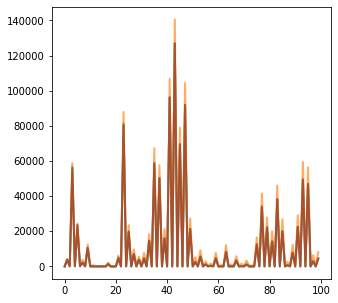

In [84]:
fig,ax = plt.subplots(figsize=(5,5))
ddd = plot_one('exp4', 'sphere', 1, ax)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

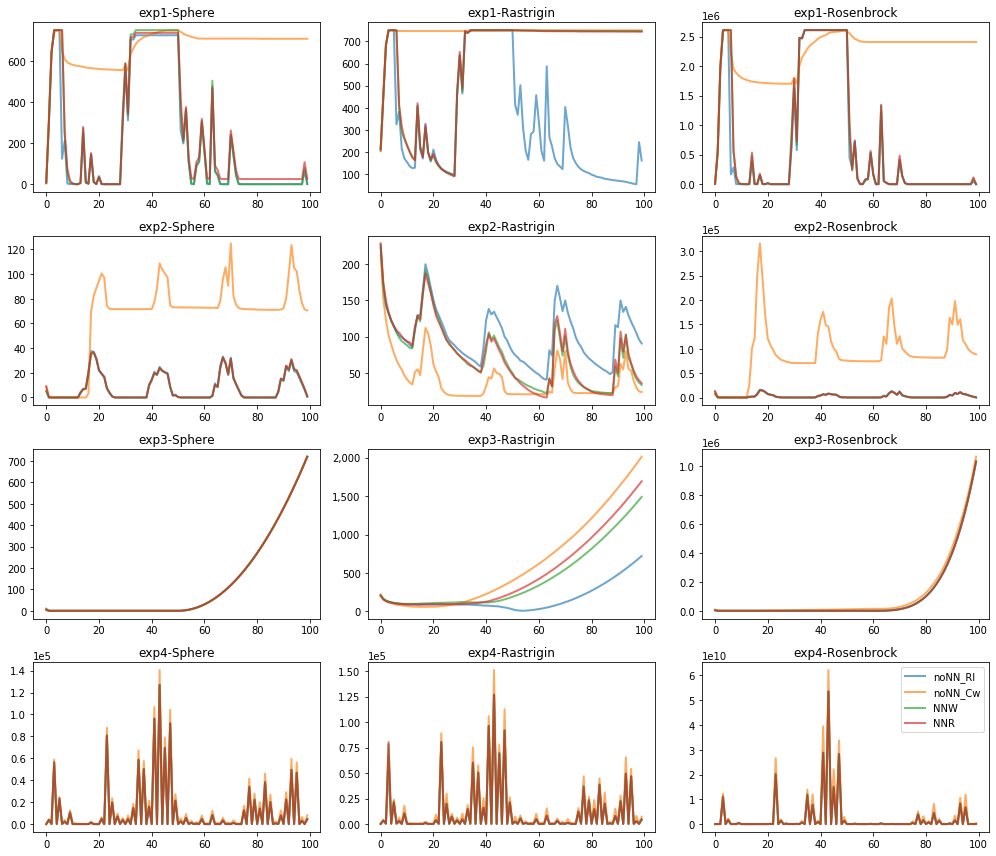

In [85]:
# Plot
fig,axs = plt.subplots(4, 3, figsize=(14,12))
lbl_dict = {'NNnorm_Worst_fitness' :'NNW',
            'NNnorm_Random_fitness':'NNR',
            'noNNReval_fitness'    :'noNN',
            'best_known'           :'Best_known'}
lbl_dict = None

for ax_row,exp in zip(axs,exps):
    for ax,func in zip(ax_row,funcs):
        plot_one(exp, func, freq, ax, lbl_dict)
        ax.set_title(f'{exp}-{func.title()}')
        ax.ticklabel_format(style='sci', scilimits=(0,5), useOffset=False)
        if ax.get_ylim()[1] < 1e5:
            ax.get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
        
ax.legend(loc='upper right')#, bbox_to_anchor=(0,0, 0.5, 0.5))#best(0, -0.90, 0.5, 0.5)
plt.tight_layout()
freq_lbl = f'{freq*10:02.0f}' if freq<1 else freq
fig.savefig(f'../../data/cluster_results/fitness{freq_lbl}.eps', dpi=400, format='eps')

[PosixPath('../../data/cluster_results/exp1/rastrigin/freq1nn_w5nn_p3nn_s3nn_tw5nn_bs4nn_epoch3diversityCw/NNnorm_Random_fitness.csv'), PosixPath('../../data/cluster_results/exp1/rastrigin/freq1nn_w5nn_p3nn_s3nn_tw5nn_bs4nn_epoch3diversityCw/NNnorm_Random_fitness.csv'), PosixPath('../../data/results/exp1/rastrigin/best_known.csv')]
[PosixPath('../../data/cluster_results/exp2/rastrigin/freq1nn_w5nn_p3nn_s3nn_tw5nn_bs4nn_epoch3diversityCw/NNnorm_Random_fitness.csv'), PosixPath('../../data/cluster_results/exp2/rastrigin/freq1nn_w5nn_p3nn_s3nn_tw5nn_bs4nn_epoch3diversityCw/NNnorm_Random_fitness.csv'), PosixPath('../../data/results/exp2/rastrigin/best_known.csv')]
[PosixPath('../../data/cluster_results/exp3/rastrigin/freq1nn_w5nn_p3nn_s3nn_tw5nn_bs4nn_epoch3diversityCw/NNnorm_Random_fitness.csv'), PosixPath('../../data/cluster_results/exp3/rastrigin/freq1nn_w5nn_p3nn_s3nn_tw5nn_bs4nn_epoch3diversityCw/NNnorm_Random_fitness.csv'), PosixPath('../../data/results/exp3/rastrigin/best_known.csv')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

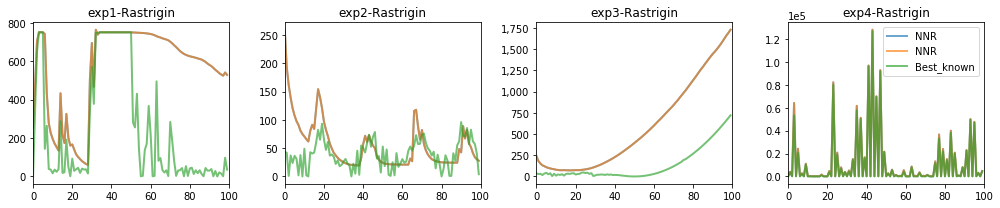

In [19]:
# Plot
fig,axs = plt.subplots(1, 4, figsize=(14,3))
lbl_dict = {'NNnorm_Worst_fitness' :'NNW',
            'NNnorm_Random_fitness':'NNR',
            'noNNReval_fitness'    :'noNN',
            'best_known'           :'Best_known'}

for ax,exp in zip(axs,exps):
    func = 'rastrigin'
    plot_one(exp, func, freq, ax, lbl_dict)
    ax.set_title(f'{exp}-{func.title()}')
    ax.ticklabel_format(style='sci', scilimits=(0,5), useOffset=False)
    ax.set_xlim(0,100)
    if ax.get_ylim()[1] < 1e5:
        ax.get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
        
ax.legend(loc='upper right')#, bbox_to_anchor=(0,0, 0.5, 0.5))#best(0, -0.90, 0.5, 0.5)
plt.tight_layout()
freq_lbl = f'{freq*10:02.0f}' if freq<1 else freq
fig.savefig(f'../../data/cluster_results/fitness_ras_.eps', dpi=400, format='eps')